In [ ]:
from src.networks.speech_separation import SpeechbrainSepformer
from src.dataset import LibriWHAM
from torchmetrics.functional import scale_invariant_signal_distortion_ratio
import torch

dataset = LibriWHAM(length_seconds=4.096, train=False, return_pair=True)
x0, x1 = dataset[0]
x0 = x0.unsqueeze(0)
x1 = x1.unsqueeze(0)
model = SpeechbrainSepformer()
with torch.no_grad():
    out = model.separate(x1)

from IPython.display import Audio, display  
display(Audio(x1.squeeze().numpy(), rate=16000))
display(Audio(out.squeeze().detach().numpy(), rate=16000, normalize=False))

sisdri = scale_invariant_signal_distortion_ratio(out, x0, zero_mean=True) - scale_invariant_signal_distortion_ratio(x1, x0, zero_mean=True)
print(sisdri)

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/sepformer-wham16k-enhancement' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/sepformer-wham16k-enhancement' if not cached


Setting SNR range to -2 to 5 dB for LibriWHAM test set


INFO:speechbrain.utils.fetching:Fetch encoder.ckpt: Fetching from HuggingFace Hub 'speechbrain/sepformer-wham16k-enhancement' if not cached
INFO:speechbrain.utils.fetching:Fetch masknet.ckpt: Fetching from HuggingFace Hub 'speechbrain/sepformer-wham16k-enhancement' if not cached
INFO:speechbrain.utils.fetching:Fetch decoder.ckpt: Fetching from HuggingFace Hub 'speechbrain/sepformer-wham16k-enhancement' if not cached
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: encoder, masknet, decoder
/work3/s214630/Latent-DSB/.venv/lib/python3.11/site-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default valu

Loaded SpeechbrainSepformer from sepformer-wham16k-enhancement with 25613569 parameters.


tensor([[8.2255]])


/work3/s214630/Latent-DSB/.venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `scale_invariant_signal_distortion_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `scale_invariant_signal_distortion_ratio` from `torchmetrics.audio` instead.
  _future_warning(


In [22]:
scale_invariant_signal_distortion_ratio(out, x0, zero_mean=True)

tensor([[9.1098]])

In [23]:
"""
Heuristic dereverberation using WPE.
Based on https://github.com/fgnt/nara_wpe/tree/master
and https://www.audiolabs-erlangen.de/media/pages/resources/aps-w23/papers/259461a00d-1663358899/sap_Yoshioka2012.pdf
"""

from nara_wpe.utils import stft, istft, get_stft_center_frequencies
import torch
from nara_wpe.wpe import wpe

class WPE:
    def __init__(self):
        self.taps = 10
        self.delay = 3
        self.iterations = 5
        self.stft_size=512
        self.stft_shift=128
        
    def encode(self, x : torch.Tensor) -> torch.Tensor: return x
    def decode(self, x : torch.Tensor) -> torch.Tensor: return x
    def to(self, device : str) -> None: ...
    
    def dereverb(self, audio : torch.Tensor) -> torch.Tensor:
        device = audio.device
        processed = []
        
        for frame in audio:
            frame = frame.cpu().numpy()
            Y = stft(frame, self.stft_size, self.stft_shift)
            Y = Y.transpose(2, 0, 1)
            Z = wpe(Y, taps=self.taps, delay=self.delay, iterations=self.iterations, statistics_mode='full')
            dereverb = istft(Z.transpose(1, 2, 0), size=self.stft_size, shift=self.stft_shift)
            processed.append(torch.tensor(dereverb, device=device))

        processed = torch.stack(processed).to(device)
        return processed

In [ ]:
from torch.utils.data import Dataset
from src.dataset import ClippedLibri, LibriRIR, LibriWHAM
import torch
import os

def make_test_dataset(dataset : Dataset, num_samples : int, path : str):
    os.makedirs(path, exist_ok=True)
    
    for i in range(num_samples):
        x0, x1 = dataset[i]
        data = {"x0": x0, "x1": x1}
        torch.save(data, path + f"/batch_{i}")

what_test = "noise"
sample_rate = 16000

if what_test == "clip":
    dataset = ClippedLibri(length_seconds=5.0, sample_rate=sample_rate, train=False, return_pair=True)
    gain_db = dataset.what_db_for_snr(target_snr=2.0)
    dataset.gain_min, dataset.gain_max = gain_db, gain_db
    
elif what_test == "rir":
    dataset = LibriRIR(length_seconds=5.0, sample_rate=sample_rate, train=False, return_pair=True)

elif what_test == 'noise':
    dataset = LibriWHAM(length_seconds=5.0, sample_rate=sample_rate, train=False, return_pair=True)


path = f"/work3/s214630/data/{what_test}"
# make_test_dataset(dataset, 512, path)

Setting SNR range to -2 to 5 dB for LibriWHAM test set


In [2]:
from src.dataset import AllLibri
dataset = AllLibri(length_seconds=4.096, sample_rate=16000, train=False)
import torch
from src.callbacks.utils import get_batch_from_dataset
# batch = get_batch_from_dataset(dataset, 5, shuffle=False)
batch = torch.randn(1, 1, int(16_000 * 10))
from src.networks.encoders import HifiGan
import torch

encoder = HifiGan()
with torch.no_grad():
    encoded = encoder.encode(batch)
    decoded = encoder.decode(encoded)

In [13]:
import torchaudio
for i in range(batch.size(0)):
    audio = torch.cat([
        batch[i].flatten(),
        decoded[i].flatten(),
    ], dim=0)
    torchaudio.save(f"samples/reconstruction_{i}.wav", audio.unsqueeze(0).cpu(), 16000)

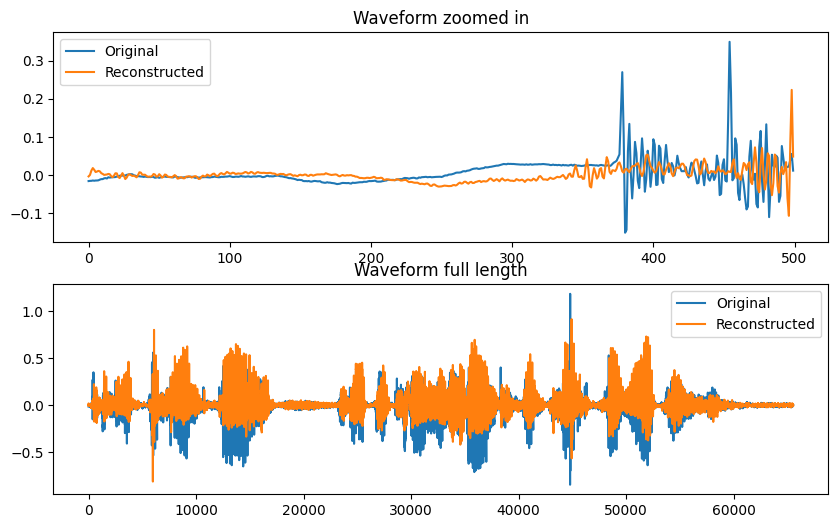

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 6))
axs : list[plt.Axes]
N = 500
axs[0].plot(batch[0, 0, :N], label="Original")
axs[0].plot(decoded[0, 0, :N], label="Reconstructed")
axs[0].legend()
axs[0].set_title("Waveform zoomed in")

axs[1].plot(batch[0, 0, :], label="Original")
axs[1].plot(decoded[0, 0, :], label="Reconstructed")
axs[1].legend()
axs[1].set_title("Waveform full length")


plt.show()

In [2]:
from src.networks import UNetModel
model = UNetModel(
    image_size=256,
    in_channels=2,
    out_channels=2,
    model_channels=64,
    num_res_blocks=2,
    attention_resolutions=[16, 8],
    dropout=0.1,
    channel_mult=[1, 2, 4, 6],
    num_classes=2,
    num_heads=4,
)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params/1e6:.2f}M")

Number of parameters: 40.77M


In [83]:
import torch.nn as nn
from torch import Tensor
from typing import Dict
import torch.nn.functional as F
from typing import Optional, Literal
import torch

Data = Dict[str, Tensor]

class STFTLoss(nn.Module):
    def __init__(
        self, 
        weights : Optional[Dict[str, float]] = None,
        polar_encoding : bool = False,
        complex_mode : Literal['l1', 'cos']  = 'l1'
        ):
        super().__init__()
        self.weights = {'sc': 1.0, 'logmag': 1.0, 'complex': 0.1}
        if weights is not None:
            self.weights.update(weights)
        self.polar_encoding = polar_encoding
        self.complex_mode = complex_mode
        assert complex_mode in ['l1', 'cos'], "complex_mode must be 'l1' or 'cos'"
            
    def stft_features(self, x : Tensor) -> Data:
        real, imag = x[:,0], x[:,1]
        mag = torch.sqrt(real**2 + imag**2)
        log_mag = torch.log(mag + 1e-8)
        phase = torch.atan2(imag, real)
        return {
            'mag': mag,
            'log_mag': log_mag,
            'phase': phase,
            'stft': x,
        }
            
    def polar_features(self, x : Tensor) -> Data:
        # a polar encoding is a 3-channel representation of the STFT
        # first channel is the log-magnitude, second and third channels are the cosine and sine of the phase
        log_mag = x[:, 0].clamp(max=10) # avoid too large values for numerical stability since we exponentiate later
        mag = log_mag.exp()
        cos_phase = x[:, 1]
        sin_phase = x[:, 2]
        phase = torch.atan2(sin_phase, cos_phase)
        stft = torch.stack([mag * cos_phase, mag * sin_phase], dim=1)
        return {
            'mag': mag,
            'log_mag': log_mag,
            'phase': phase,
            'stft': stft,
        }
        
    def forward(self, batch: Data) -> Tensor:
        x_hat, x = batch["out"], batch["target"]
        
        if self.polar_encoding:
            features_x = self.polar_features(x)
            features_xhat = self.polar_features(x_hat)
        else:
            features_x = self.stft_features(x)
            features_xhat = self.stft_features(x_hat)
        
        # spectral convergence
        num = torch.norm(features_x['mag'] - features_xhat['mag'], p='fro', dim=(1,2))
        den = torch.norm(features_x['mag'], p='fro', dim=(1,2)).clamp(min=1e-8)
        loss_sc = (num / den).mean()
        
        # log-magnitude
        loss_logmag = F.l1_loss(features_x['log_mag'], features_xhat['log_mag'])
        
        # phase aware loss
        if self.complex_mode == 'cos':
            phi_x = features_x['phase']
            phi_y = features_xhat['phase']
            loss_phase = (1 - torch.cos(phi_x - phi_y)).mean()
        elif self.complex_mode == 'l1':
            loss_phase = F.l1_loss(features_x['stft'], features_xhat['stft'])
                
        loss = (
            self.weights['sc'] * loss_sc +
            self.weights['logmag'] * loss_logmag +
            self.weights['complex'] * loss_phase
        )
        
        return {
            "sc_loss": loss_sc,
            "logmag_loss": loss_logmag,
            "complex_loss": loss_phase,
            "loss": loss
        }

In [1]:
import torch
from src.dataset import LibriWHAM
from src.networks.encoders import STFTEncoderDecoder, PolarSTFTEncoderDecoder

dataset = LibriWHAM(length_seconds=4.096, train=False, return_pair=True)
x0, x1 = dataset[0]
x0, x1 = x0.unsqueeze(0), x1.unsqueeze(0)

encoder = STFTEncoderDecoder(n_fft=512, hop_length=128)
x0 = encoder.encode(x0)
x1 = encoder.encode(x1)

INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []


Setting SNR range to -2 to 5 dB for LibriWHAM test set


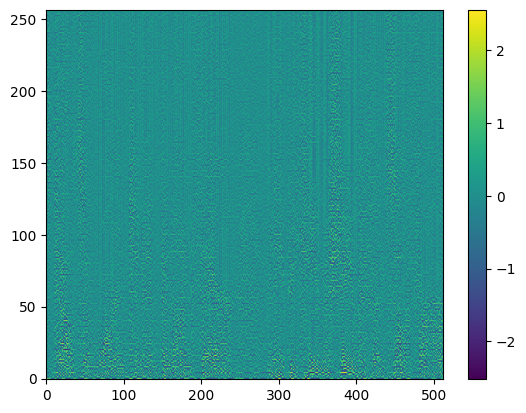

In [48]:
import matplotlib.pyplot as plt

eps = 1e-2
amp = x0[0, 0].abs()
sign = x0[0, 0].sign()

def f(x):
    return torch.log(1 + x / eps)

def g(x):
    return x / (x + eps)

def h(x):
    return torch.log(1 + x)  # log(1 + x)

def k(x):
    return x / (1 + x)  # x / (1 + x)

def j(x):
    return x ** 0.25

y = sign * j(amp)
plt.imshow(y, aspect='auto', origin='lower')
# add colorbar
plt.colorbar()
plt.show()

In [ ]:
from typing import Dict
from torch import Tensor
import torch

TensorDict = Dict[str, Tensor]

class BaggeScheduler:
    def __init__(
        self,
        beta : float = 2.0,
    ):
        self.beta = beta
        
    @staticmethod
    def to_dim(x: Tensor, dim: int) -> Tensor:
        while x.dim() < dim:
            x = x.unsqueeze(-1)
        return x
        
    def sample_training_step(self, x0: Tensor, x1: Tensor, timesteps: Tensor) -> TensorDict:        
        t = self.to_dim(timesteps, x0.dim())
        mu_t = (1 - t) * x0 + t * x1
        sigma_t = self.beta * t * (1 - t)
        noise = torch.randn_like(mu_t)
        xt = mu_t + sigma_t ** 0.5 * noise
        flow = x1 - x0
        
        return {
            "xt": xt,
            "noise": noise,
            "flow": flow,
            "timesteps": timesteps,
        }
        
    def step(self, xt: Tensor, flow: Tensor, noise: Tensor, tk: float, tk_plus_one: float, forward: bool) -> Tensor:
        delta_t = tk_plus_one - tk
        b = self.beta
        
        if forward:
            drift = flow - torch.sqrt(b * tk / (1 - tk)) * noise
            mu_next = xt + delta_t * drift
            sigma_next = b * delta_t * (1 - tk_plus_one) / (1 - tk)
        else:
            drift = flow + torch.sqrt(b * (1 - tk) / tk) * noise
            mu_next = xt - delta_t * drift
            sigma_next = b * delta_t * tk / tk_plus_one
            
        noise = torch.randn_like(xt)
        xt_next = mu_next + sigma_next ** 0.5 * noise
        return xt_next